# Data Mining Project - WNBA Playoffs Prediction - G24

## Business Understanding

#### Our data
Basketball tournaments are usually split in two parts. First, all teams play each other aiming to achieve the greatest number of wins possible. Then, at the end of the first part of the season, a pre determined number of teams which were able to win the most games are qualified to the playoff season, where they play series of knock-out matches for the trophy.

For the 10 years, data from players, teams, coaches, games and several other metrics were gathered and arranged on this dataset. The goal is to use this data to predict which teams will qualify for the playoffs in the next season.



#### Competition Format
The 12 teams in the WNBA are split into an Eastern Conference and a Western Conference. WNBA fixtures begin with preseason games in May before each team plays 20 home games and 20 road games during the regular season.

The aim for every team is to qualify for the Playoffs, which begin in September each year.

The WNBA teams with the eight best regular season records regardless of standing qualify for the Playoffs. Higher seeds matchup with lower seeds, so the top seed faces the eight seed, the second seed faces the seven seed and so on.

When it comes to betting on the Playoffs, the first round are best-of-three series. The semifinals and final are both best-of-five, meaning WNBA teams need to record three wins to claim victory in the series.

## Database Connection

We used a free service to host our database. The Database is in PostgreSQL.

In [1]:
import json
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE

In [2]:
# DB Credentials
with open("../config.json") as config_file:
    config = json.load(config_file)

host = config["db_host"]
user = config["db_user"]
password = config["db_password"]
database = config["db_database"]
schema = config["db_schema"]

In [3]:
connection = psycopg2.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cursor = connection.cursor()

def execute(query):
    cursor.execute(query)
    connection.commit()
    return cursor.fetchall()

def fetch(query):
    cursor.execute(query)
    return cursor.fetchall()

SELECT = "SELECT * FROM " + schema + "." # + table_name 
INSERT = "INSERT INTO " + schema + "." # + table_name + " VALUES " + values
UPDATE = "UPDATE " + schema + "." # + table_name + " SET " + column_name + " = " + value
DELETE = "DELETE FROM " + schema + "."  # + table_name + " WHERE " + column_name + " = " + value

 The data about the players, teams and coaches consist of following relations:

    awards_players (96 objects) - each record describes awards and prizes received by players across 10 seasons,
    coaches (163 objects) - each record describes all coaches who've managed the teams during the time period,
    players (894 objects) - each record contains details of all players,
    players_teams (1877 objects) - each record describes the performance of each player for each team they played,
    series_post (71 objects) - each record describes the series' results,
    teams (143 objects) - each record describes the performance of the teams for each season,
    teams_post (81 objects) - each record describes the results of each team at the post-season.


In [4]:
awards_players = fetch(SELECT + "awards_players") # awards and prizes received by players across 10 seasons,
coaches = fetch(SELECT + "coaches") # all coaches who've managed the teams during the time period,
players = fetch(SELECT + "players") # details of all players,
players_teams = fetch(SELECT + "players_teams") # performance of each player for each team they played,
series_post = fetch(SELECT + "series_post") # series' results,
teams = fetch(SELECT + "teams") # performance of the teams for each season,
teams_post = fetch(SELECT + "teams_post") # results of each team at the post-season.

In [5]:
#save the data in a dataframe
awards_players_df = pd.DataFrame(awards_players, columns=['playerID', 'award', 'year', 'lgID'])
coaches_df = pd.DataFrame(coaches, columns=['coachID', 'year', 'tmID', 'lgID', 'stint', 'won', 'lost', 'post_wins', 'post_losses'])
players_df = pd.DataFrame(players, columns=['bioID', 'pos', 'firstseason', 'lastseason', 'height', 'weight', 'college', 'collegeOther', 'birthDate', 'deathDate'])
players_teams_df = pd.DataFrame(players_teams, columns=['playerID', 'year', 'stint', 'tmID', 'lgID', 'GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade', 'PostthreeAttempted', 'PostthreeMade', 'PostDQ'])
series_post_df = pd.DataFrame(series_post, columns=['year', 'round', 'series', 'tmIDWinner', 'lgIDWinner', 'tmIDLoser', 'lgIDLoser', 'W', 'L'])
teams_df = pd.DataFrame(teams, columns=['year', 'lgID', 'tmID', 'franchID', 'confID', 'divID', 'rank', 'playoff', 'seeded', 'firstRound', 'semis', 'finals', 'name', 'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB', 'won', 'lost', 'GP', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'min', 'attend', 'arena'])
teams_post_df = pd.DataFrame(teams_post, columns=['year', 'tmID', 'lgID', 'W', 'L'])

#make a dictionary with all the dataframes
dfs = {'awards_players_df': awards_players_df, 'coaches_df': coaches_df, 'players_df': players_df, 'players_teams_df': players_teams_df, 'series_post_df': series_post_df, 'teams_df': teams_df, 'teams_post_df': teams_post_df}

## Data Understanding

### First approach

We started with a Exploratory Data Analysis. There are 7 different tables, with different sizes both in lines and columns

In [6]:
#for each table, print the table name, number of rows and columns
for df in dfs:
    print(df)
    print(dfs[df].shape,'\n')

awards_players_df
(95, 4) 

coaches_df
(162, 9) 

players_df
(893, 10) 

players_teams_df
(1876, 43) 

series_post_df
(70, 9) 

teams_df
(142, 61) 

teams_post_df
(80, 5) 



Before jumping into the data analysis, one of the first things we noticed is that all the tables have an "League ID" (lgID) attribute. As the WNBA is the only league we are covering, and there is no variability in this column, we can drop it, as well as other columns that may have always the same content. First and last season of a player is also empty but we will populate it later.

In [7]:
#Drop columns whose values are always the same
for df in dfs:
    for col in dfs[df].columns:
        if len(dfs[df][col].unique()) == 1 and (col != 'firstseason' or col != 'lastseason'):
            print(df, col)
            dfs[df].drop(col, axis=1, inplace=True)

awards_players_df lgID
coaches_df lgID
players_df firstseason
players_df lastseason
players_teams_df lgID
series_post_df lgIDWinner
series_post_df lgIDLoser
teams_df lgID
teams_df divID
teams_df seeded
teams_df tmORB
teams_df tmDRB
teams_df tmTRB
teams_df opptmORB
teams_df opptmDRB
teams_df opptmTRB
teams_post_df lgID


Before continuing, we noted there are three dead players in the players table. We should take that into account when doing the analysis.

In [8]:
#print dead players
print(players_df[players_df['deathDate'] != '0000-00-00'])

          bioID pos  height  weight            college collegeOther  \
225  dydekma01w   C     9.0     223                                   
605  perroki01w   G    65.0     130       SW Louisiana                
625  priceka01w   G    70.0     148  Stephen F. Austin                
881  yasenco01w   G    72.0     160             Purdue                

      birthDate   deathDate  
225  1974-04-28  2011-05-27  
605  1967-01-18  1999-08-19  
625  1975-12-03  1999-01-18  
881  1973-12-05  2001-05-12  


Also, there are players that have not played any season of the seasons given. There are 338 players that have not played any season.

In [9]:
#players that have not played in the last 10 years
print("Number of players that haven't played: " + 
      str(fetch("SELECT Count(p.bioid) FROM wnba.players p WHERE p.bioid not in (select pt.playerid  from wnba.players_teams pt)")[0][0]))

Number of players that haven't played: 338


#### Describing the data

For starters, we printed the head of each table, to get a sense of the data

In [10]:
# do a head of each table
for df in dfs:
    print(df)
    display(dfs[df].head())

awards_players_df


,playerID,award,year
0,thompti01w,All-Star Game Most Valuable Player,1
1,leslili01w,All-Star Game Most Valuable Player,2
2,leslili01w,All-Star Game Most Valuable Player,3
3,teaslni01w,All-Star Game Most Valuable Player,4
4,swoopsh01w,All-Star Game Most Valuable Player,6


coaches_df


,coachID,year,tmID,stint,won,lost,post_wins,post_losses
0,adamsmi01w,5,WAS,0,17,17,1,2
1,adubari99w,1,NYL,0,20,12,4,3
2,adubari99w,2,NYL,0,21,11,3,3
3,adubari99w,3,NYL,0,18,14,4,4
4,adubari99w,4,NYL,0,16,18,0,0


players_df


,bioID,pos,height,weight,college,collegeOther,birthDate,deathDate
0,abrahta01w,C,74.0,190,George Washington,,1975-09-27,0000-00-00
1,abrossv01w,F,74.0,169,Connecticut,,1980-07-09,0000-00-00
2,adairje01w,C,76.0,197,George Washington,,1986-12-19,0000-00-00
3,adamsda01w,F-C,73.0,239,Texas A&M,Jefferson College (JC),1989-02-19,0000-00-00
4,adamsjo01w,C,75.0,180,New Mexico,,1981-05-24,0000-00-00


players_teams_df


,playerID,year,stint,tmID,GP,GS,minutes,points,oRebounds,dRebounds,...,PostBlocks,PostTurnovers,PostPF,PostfgAttempted,PostfgMade,PostftAttempted,PostftMade,PostthreeAttempted,PostthreeMade,PostDQ
0,abrossv01w,2,0,MIN,26,23,846,343,43,131,...,0,0,0,0,0,0,0,0,0,0
1,abrossv01w,3,0,MIN,27,27,805,314,45,101,...,0,0,0,0,0,0,0,0,0,0
2,abrossv01w,4,0,MIN,30,25,792,318,44,97,...,1,8,8,22,6,8,8,7,3,0
3,abrossv01w,5,0,MIN,22,11,462,146,17,57,...,2,3,7,23,8,4,2,8,2,0
4,abrossv01w,6,0,MIN,31,31,777,304,29,78,...,0,0,0,0,0,0,0,0,0,0


series_post_df


,year,round,series,tmIDWinner,tmIDLoser,W,L
0,1,FR,A,CLE,ORL,2,1
1,1,FR,B,NYL,WAS,2,0
2,1,FR,C,LAS,PHO,2,0
3,1,FR,D,HOU,SAC,2,0
4,1,CF,E,HOU,LAS,2,0


teams_df


,year,tmID,franchID,confID,rank,playoff,firstRound,semis,finals,name,...,GP,homeW,homeL,awayW,awayL,confW,confL,min,attend,arena
0,9,ATL,ATL,EA,7,N,,,,Atlanta Dream,...,34,1,16,3,14,2,18,6825,141379,Philips Arena
1,10,ATL,ATL,EA,2,Y,L,,,Atlanta Dream,...,34,12,5,6,11,10,12,6950,120737,Philips Arena
2,1,CHA,CHA,EA,8,N,,,,Charlotte Sting,...,32,5,11,3,13,5,16,6475,90963,Charlotte Coliseum
3,2,CHA,CHA,EA,4,Y,W,W,L,Charlotte Sting,...,32,11,5,7,9,15,6,6500,105525,Charlotte Coliseum
4,3,CHA,CHA,EA,2,Y,L,,,Charlotte Sting,...,32,11,5,7,9,12,9,6450,106670,Charlotte Coliseum


teams_post_df


,year,tmID,W,L
0,1,HOU,6,0
1,1,ORL,1,2
2,1,CLE,3,3
3,1,WAS,0,2
4,1,NYL,4,3


Having an idea of what the data looks like, we now want to see a more detailed description to get more information

In [11]:
# do a describe of each table
for df in dfs:
    print(df)
    display(dfs[df].describe(include='all'))

awards_players_df


,playerID,award,year
count,95,95,95.000000
unique,58,12,NaN
top,leslili01w,Coach of the Year,NaN
freq,10,10,NaN
mean,NaN,NaN,5.789474
std,NaN,NaN,2.747900
min,NaN,NaN,1.000000
25%,NaN,NaN,3.500000
50%,NaN,NaN,7.000000
75%,NaN,NaN,8.000000


coaches_df


,coachID,year,tmID,stint,won,lost,post_wins,post_losses
count,162,162.000000,162,162.000000,162.000000,162.000000,162.000000,162.000000
unique,57,NaN,20,NaN,NaN,NaN,NaN,NaN
top,donovan99w,NaN,WAS,NaN,NaN,NaN,NaN,NaN
freq,9,NaN,13,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.314815,NaN,0.364198,14.672840,14.623457,1.166667,1.172840
std,NaN,2.896715,NaN,0.693861,6.403445,5.678789,1.953656,1.316782
min,NaN,1.000000,NaN,0.000000,0.000000,2.000000,0.000000,0.000000
25%,NaN,3.000000,NaN,0.000000,10.000000,11.000000,0.000000,0.000000
50%,NaN,5.000000,NaN,0.000000,16.000000,15.000000,0.000000,0.000000
75%,NaN,8.000000,NaN,0.000000,18.750000,18.000000,1.000000,2.000000


players_df


,bioID,pos,height,weight,college,collegeOther,birthDate,deathDate
count,893,893,893.000000,893.000000,893,893,893,893
unique,893,8,NaN,NaN,161,12,764,5
top,abrahta01w,G,NaN,NaN,,,0000-00-00,0000-00-00
freq,1,309,NaN,NaN,167,882,84,889
mean,NaN,NaN,65.500560,145.415454,NaN,NaN,NaN,NaN
std,NaN,NaN,20.940425,61.275703,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,68.000000,140.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,72.000000,162.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,75.000000,180.000000,NaN,NaN,NaN,NaN


players_teams_df


,playerID,year,stint,tmID,GP,GS,minutes,points,oRebounds,dRebounds,...,PostBlocks,PostTurnovers,PostPF,PostfgAttempted,PostfgMade,PostftAttempted,PostftMade,PostthreeAttempted,PostthreeMade,PostDQ
count,1876,1876.000000,1876.000000,1876,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,...,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000
unique,555,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,smithka01w,NaN,NaN,PHO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,11,NaN,NaN,152,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.326226,0.113539,NaN,24.320896,12.438166,501.269190,176.261727,24.388060,54.334755,...,0.759062,2.623134,3.735075,12.282516,5.149254,3.672708,2.822495,2.924307,1.019723,0.026652
std,NaN,2.905475,0.422574,NaN,10.460614,13.641697,359.566117,161.983839,23.325974,48.347088,...,2.280011,5.037807,6.697874,24.313379,10.726421,8.463917,6.723170,7.751034,2.992637,0.170751
min,NaN,1.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,3.000000,0.000000,NaN,17.000000,0.000000,165.000000,41.000000,6.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,5.000000,0.000000,NaN,29.000000,5.000000,459.000000,129.000000,18.000000,42.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,8.000000,0.000000,NaN,32.000000,29.000000,826.250000,284.000000,36.000000,83.000000,...,0.000000,3.000000,5.000000,15.000000,6.000000,4.000000,2.000000,1.000000,0.000000,0.000000


series_post_df


,year,round,series,tmIDWinner,tmIDLoser,W,L
count,70.00000,70,70,70,70,70.000000,70.000000
unique,NaN,3,7,14,18,NaN,NaN
top,NaN,FR,A,LAS,SAC,NaN,NaN
freq,NaN,40,10,12,7,NaN,NaN
mean,5.50000,NaN,NaN,NaN,NaN,2.071429,0.614286
std,2.89302,NaN,NaN,NaN,NaN,0.259399,0.572127
min,1.00000,NaN,NaN,NaN,NaN,2.000000,0.000000
25%,3.00000,NaN,NaN,NaN,NaN,2.000000,0.000000
50%,5.50000,NaN,NaN,NaN,NaN,2.000000,1.000000
75%,8.00000,NaN,NaN,NaN,NaN,2.000000,1.000000


teams_df


,year,tmID,franchID,confID,rank,playoff,firstRound,semis,finals,name,...,GP,homeW,homeL,awayW,awayL,confW,confL,min,attend,arena
count,142.000000,142,142,142,142.000000,142,142,142,142,142,...,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142
unique,NaN,20,18,2,NaN,2,3,3,3,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
top,NaN,MIN,WAS,WE,NaN,Y,,,,Minnesota Lynx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Verizon Center
freq,NaN,10,10,72,NaN,80,62,104,122,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
mean,5.302817,NaN,NaN,NaN,4.084507,NaN,NaN,NaN,NaN,NaN,...,33.323944,10.169014,6.492958,6.492958,10.169014,10.563380,10.563380,6735.683099,141050.253521,NaN
std,2.917274,NaN,NaN,NaN,2.095226,NaN,NaN,NaN,NaN,NaN,...,0.949425,2.994017,2.967308,2.702104,2.731409,3.485461,3.485461,197.851093,34714.358519,NaN
min,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,32.000000,1.000000,0.000000,1.000000,3.000000,2.000000,2.000000,6400.000000,57635.000000,NaN
25%,3.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,...,32.000000,8.000000,4.250000,5.000000,9.000000,8.000000,8.000000,6500.000000,120897.500000,NaN
50%,5.000000,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,...,34.000000,11.000000,6.000000,6.000000,10.000000,11.000000,10.000000,6825.000000,135895.500000,NaN
75%,8.000000,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,...,34.000000,12.000000,8.000000,8.000000,12.000000,13.000000,13.000000,6875.000000,150441.500000,NaN


teams_post_df


,year,tmID,W,L
count,80.000000,80,80.000000,80.000000
unique,NaN,18,NaN,NaN
top,NaN,LAS,NaN,NaN
freq,NaN,9,NaN,NaN
mean,5.500000,NaN,2.350000,2.350000
std,2.890403,NaN,2.228129,0.843441
min,1.000000,NaN,0.000000,0.000000
25%,3.000000,NaN,1.000000,2.000000
50%,5.500000,NaN,1.500000,2.000000
75%,8.000000,NaN,3.250000,3.000000


In [12]:
# do a info of each table
for df in dfs:
    print(df)
    print(dfs[df].info(), '\n')

awards_players_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   playerID  95 non-null     object
 1   award     95 non-null     object
 2   year      95 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ KB
None 

coaches_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   coachID      162 non-null    object
 1   year         162 non-null    int64 
 2   tmID         162 non-null    object
 3   stint        162 non-null    int64 
 4   won          162 non-null    int64 
 5   lost         162 non-null    int64 
 6   post_wins    162 non-null    int64 
 7   post_losses  162 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 10.2+ KB
None 

players_df
<class 'pandas.core.frame.DataFrame'>
R

With the info and describes we understand that:
- There are no Null entries (although there values that are simply an empty string), as we will also prove next.
- There are some columns with the DataType "object", most of them being strings.
- There are binary objects (like confID and playoff, in the 'teams' table, with the values "Y" or "N") that could be substituted by a binary, as well as ternary objects (like the firstRound, semis and finals in the 'teams' table, with the values "W", "L" or "") that could also be transformed.

In [13]:
# do a isnull of each table to see if there are null values
for df in dfs:
    print(df)
    print(dfs[df].isnull().sum(), '\n')

awards_players_df
playerID    0
award       0
year        0
dtype: int64 

coaches_df
coachID        0
year           0
tmID           0
stint          0
won            0
lost           0
post_wins      0
post_losses    0
dtype: int64 

players_df
bioID           0
pos             0
height          0
weight          0
college         0
collegeOther    0
birthDate       0
deathDate       0
dtype: int64 

players_teams_df
playerID              0
year                  0
stint                 0
tmID                  0
GP                    0
GS                    0
minutes               0
points                0
oRebounds             0
dRebounds             0
rebounds              0
assists               0
steals                0
blocks                0
turnovers             0
PF                    0
fgAttempted           0
fgMade                0
ftAttempted           0
ftMade                0
threeAttempted        0
threeMade             0
dq                    0
PostGP                0


We wanted to see what were the different values for the objects and check if there were more objects that could be transformed into binary and ternary variables, so we printed the objects unique values and their frequencies.

In [14]:
# check the value counts for each column of type object
for df in dfs:
    print(df)
    for col in dfs[df].columns:
        if dfs[df][col].dtype == 'object':
            print(dfs[df][col].value_counts(), '\n')

awards_players_df
leslili01w    10
swoopsh01w     8
catchta01w     5
tauradi01w     4
jacksla01w     4
thibami99w     2
parkeca01w     2
lennobe01w     2
staleda01w     2
coopecy01w     2
griffyo01w     2
thompti01w     2
fordch01w      2
smithka01w     2
hugheda99w     2
mcconsu01w     2
nolande01w     1
birdsu01w      1
penicti01w     1
holdsch01w     1
boltoru01w     1
stileja01w     1
johnste01w     1
augusse01w     1
mccouan01w     1
pricear01w     1
pierspl01w     1
wiggica01w     1
bonnede01w     1
hoffmeb01w     1
rileyru01w     1
pondeca01w     1
langhcr01w     1
milleco01w     1
mccarja01w     1
palmewe01w     1
teaslni01w     1
douglka01w     1
cashsw01w      1
coopemi01w     1
stanlma99w     1
laimbbi01w     1
whisejo99w     1
meadoma99w     1
blackde01w     1
lawsoka01w     1
wickssu01w     1
gilloje01w     1
campbed01w     1
edwarte01w     1
mcwilta01w     1
beviltu01w     1
johnsvi01w     1
phillta01w     1
arcaija01w     1
snowmi01w      1
milleke01w     1
weathte01w   

- We conclude the previous identified variables are the only objects with 2 or 3 unique values (confID and playoff, in the 'teams' table, with the values "Y" or "N" and the firstRound, semis and finals in the 'teams' table, with the values "W", "L" or "").
- There are players with no position and no college assigned ("").
- There are players with no date of birth in the record (0000-00-00).
- There is the need to do null value uniformization, as there are some columns with empty strings, others with default 0 values and other values that represent null.

We moved on to the numerical variables, trying to find outliers using boxplots (as we have a lot of variables, we only run for the ones we thought had outliers)

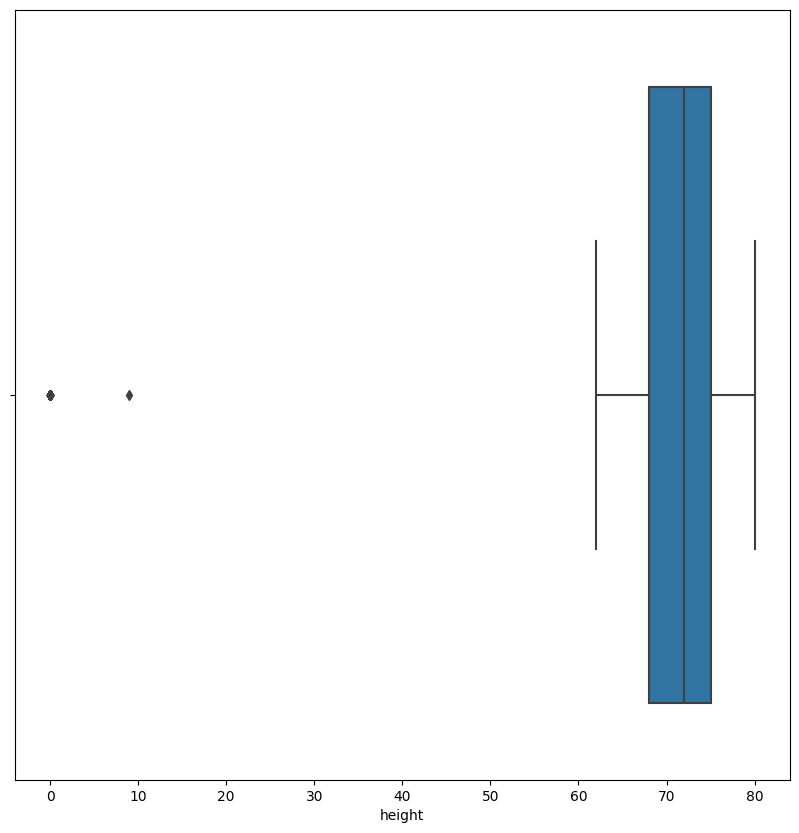

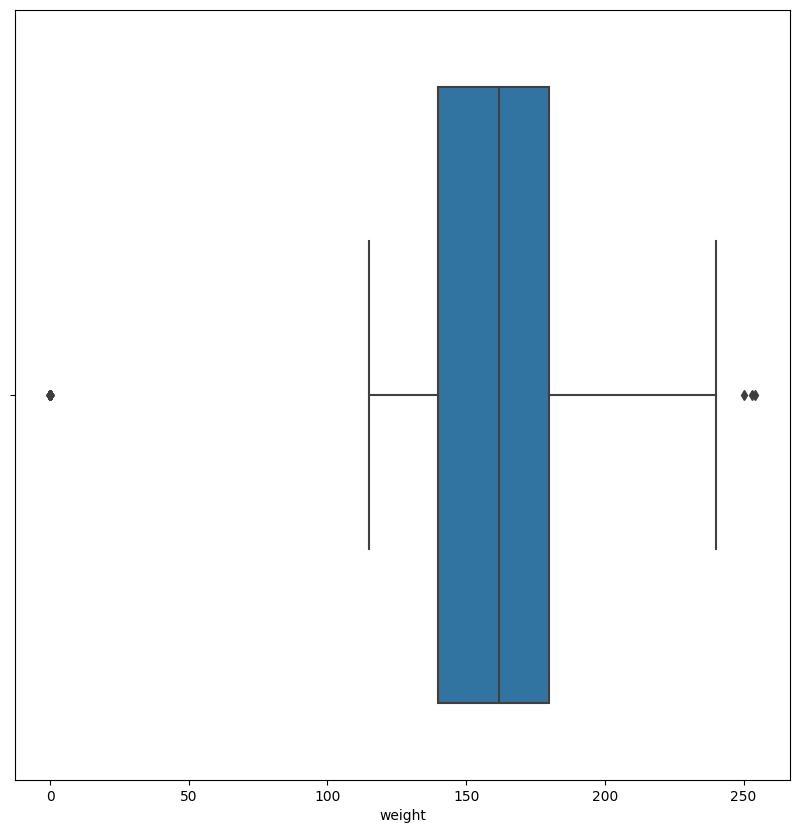

In [15]:
for df in dfs:
    # do box plots of the numerical columns
    for col in dfs[df].columns:
        if dfs[df][col].dtype != 'object':
            if col == 'height' or col == 'weight':
                plt.figure(figsize=(10, 10))
                sns.boxplot(x=dfs[df][col])
                plt.show()

- Looking at the boxplots, we can understand that the height and weight variables have default 0 values and should be treated as null values.

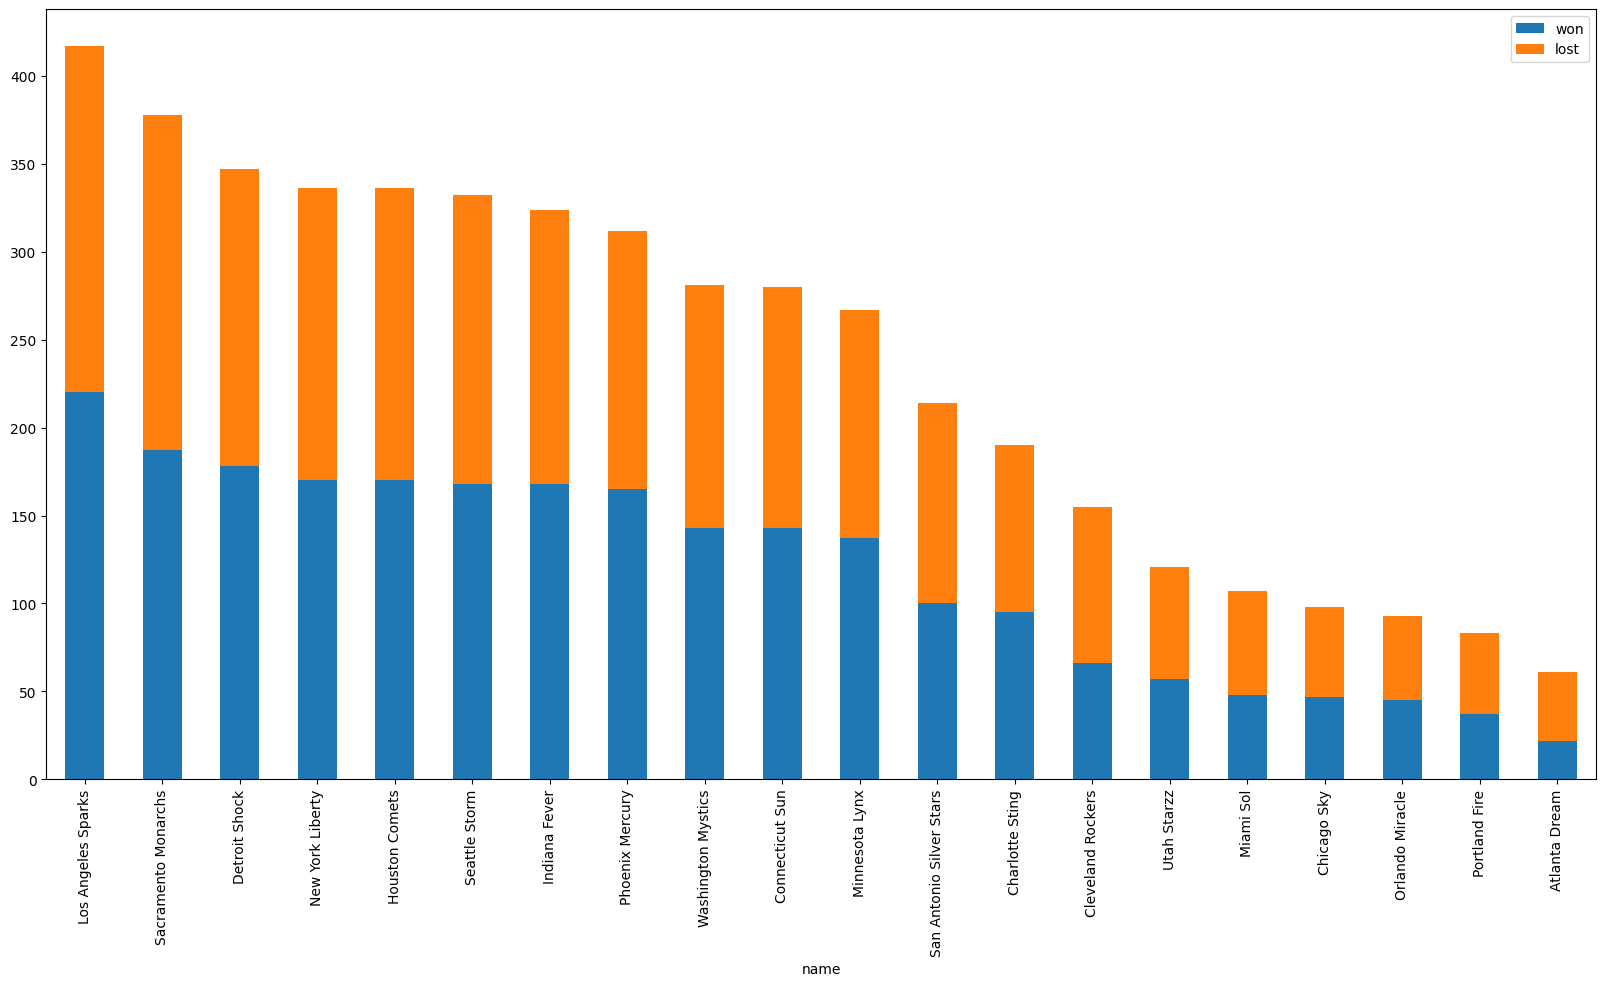

In [16]:
#wins and losses by team, sorted by number of wins: stacked bar chart
wins_by_team = teams_df.groupby('name')['won'].sum().sort_values(ascending=False)
losses_by_team = teams_df.groupby('name')['lost'].sum().sort_values(ascending=False)
wins_by_team = wins_by_team.reset_index()
losses_by_team = losses_by_team.reset_index()
wins_by_team['lost'] = losses_by_team['lost']
wins_by_team = wins_by_team.sort_values(by='won', ascending=False)
wins_by_team = wins_by_team.set_index('name')
wins_by_team.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.show()

- The number of games played by each team differs (there may be teams that are no longer playing), so we can't compare the number of wins and losses directly. We need to calculate the percentage of wins and losses for each team.

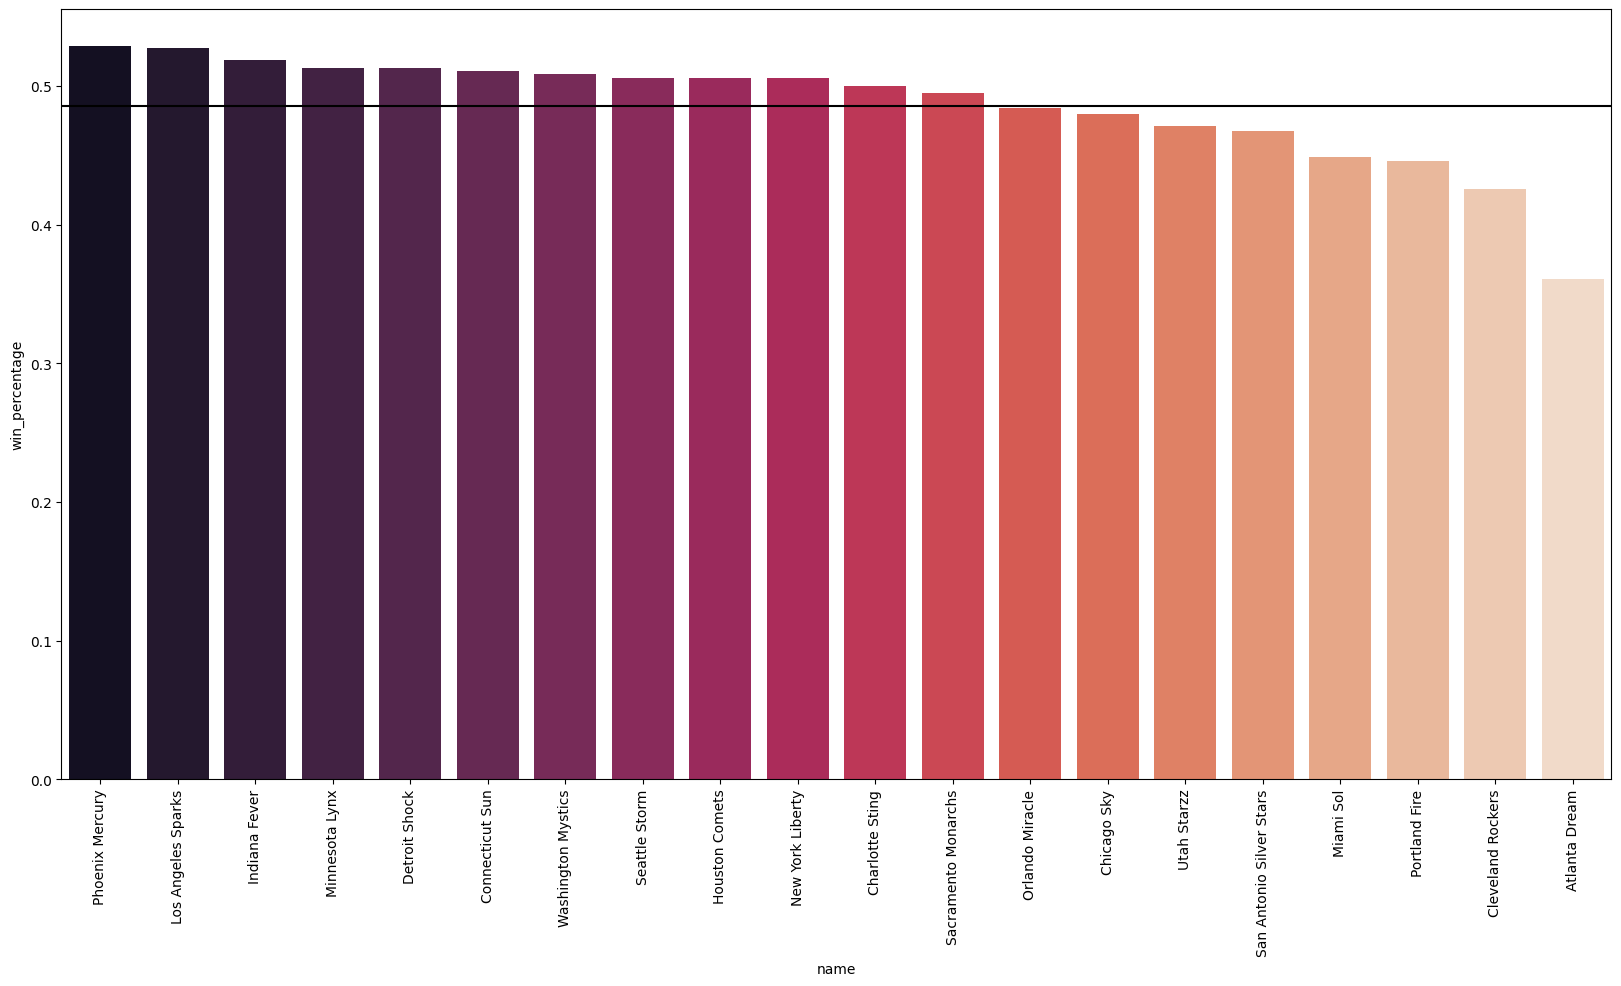

In [17]:
#win percentage by team, sorted by win percentage: bar chart with color gradient, with a horizontal line at the league average
wins_by_team['win_percentage'] = wins_by_team['won'] / (wins_by_team['won'] + wins_by_team['lost'])
wins_by_team = wins_by_team.sort_values(by='win_percentage', ascending=False)
plt.figure(figsize=(20, 10))
sns.barplot(x=wins_by_team.index, y=wins_by_team['win_percentage'], palette='rocket')
plt.axhline(wins_by_team['win_percentage'].mean(), color='black')
plt.xticks(rotation=90)
plt.show()

- In terms of win percentage, it seems like a competitive league, with more than half of the teams having a win percentage of 50% or more, taking advantage of the worst teams. There is also just one team below 40% of wins.

As we saw that there were teams it more games than the others, we want to see which teams played in which seasons, to see if there are teams that are no longer playing

In [18]:
#Enumerate the seasons a team played in the league
seasons_by_team = teams_df.groupby('name')['year']
print(seasons_by_team.unique())
print("-----------------------")
print(seasons_by_team.nunique())
#print number of seasons played
print("-----------------------")
#filter only teams that have played in the last season
teams_last_season = teams_df[teams_df['year'] == 10]
print(teams_last_season['name'].unique())


name
Atlanta Dream                                       [9, 10]
Charlotte Sting                       [1, 2, 3, 4, 5, 6, 7]
Chicago Sky                                   [7, 8, 9, 10]
Cleveland Rockers                              [1, 2, 3, 4]
Connecticut Sun                      [4, 5, 6, 7, 8, 9, 10]
Detroit Shock               [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Houston Comets                  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Indiana Fever               [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Los Angeles Sparks          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Miami Sol                                         [1, 2, 3]
Minnesota Lynx              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
New York Liberty            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Orlando Miracle                                   [1, 2, 3]
Phoenix Mercury             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Portland Fire                                     [1, 2, 3]
Sacramento Monarchs         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
San Antonio Silver Stars           

### Going deeper

There are tables with a lot of attributes (player_teams 43 and teams_df 61, for example). We will evaluate the correlations and delete the most correlated pairs of attributes.

In [19]:
MAX_CORRELATION = 0.8

In [20]:
# Add column to indicate if the player went to the playoffs to look for correlations
def went_to_playoff(df, dfs):

    returned_df = df.copy()
    
    dfs['teams_df']['playoff'] = dfs['teams_df']['playoff'].map({'Y': 1, 'N': 0})
    playoff_data = dfs['teams_df'][['tmID', 'year', 'playoff']]

    returned_df = returned_df.merge(playoff_data, on=['tmID', 'year'], how='left')
    
    return returned_df

def most_correlated(df):

    df_copy = df.copy()


    correlation_matrix = df_copy.corr()

    sorted_correlations = correlation_matrix.unstack().sort_values(ascending=False)

    plt.figure(figsize=(20, 20))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.show()

    # Get the pairs of attributes with the highest correlation values
    most_correlated_pairs = sorted_correlations[sorted_correlations > MAX_CORRELATION]
    most_correlated_pairs = most_correlated_pairs[most_correlated_pairs < 1.0]


    #repeated pairs (e.g. (a,b) and (b,a))
    most_correlated_pairs = most_correlated_pairs[::2]
    print(most_correlated_pairs)

    return df_copy

Lets run the function for all the tables

awards_players_df


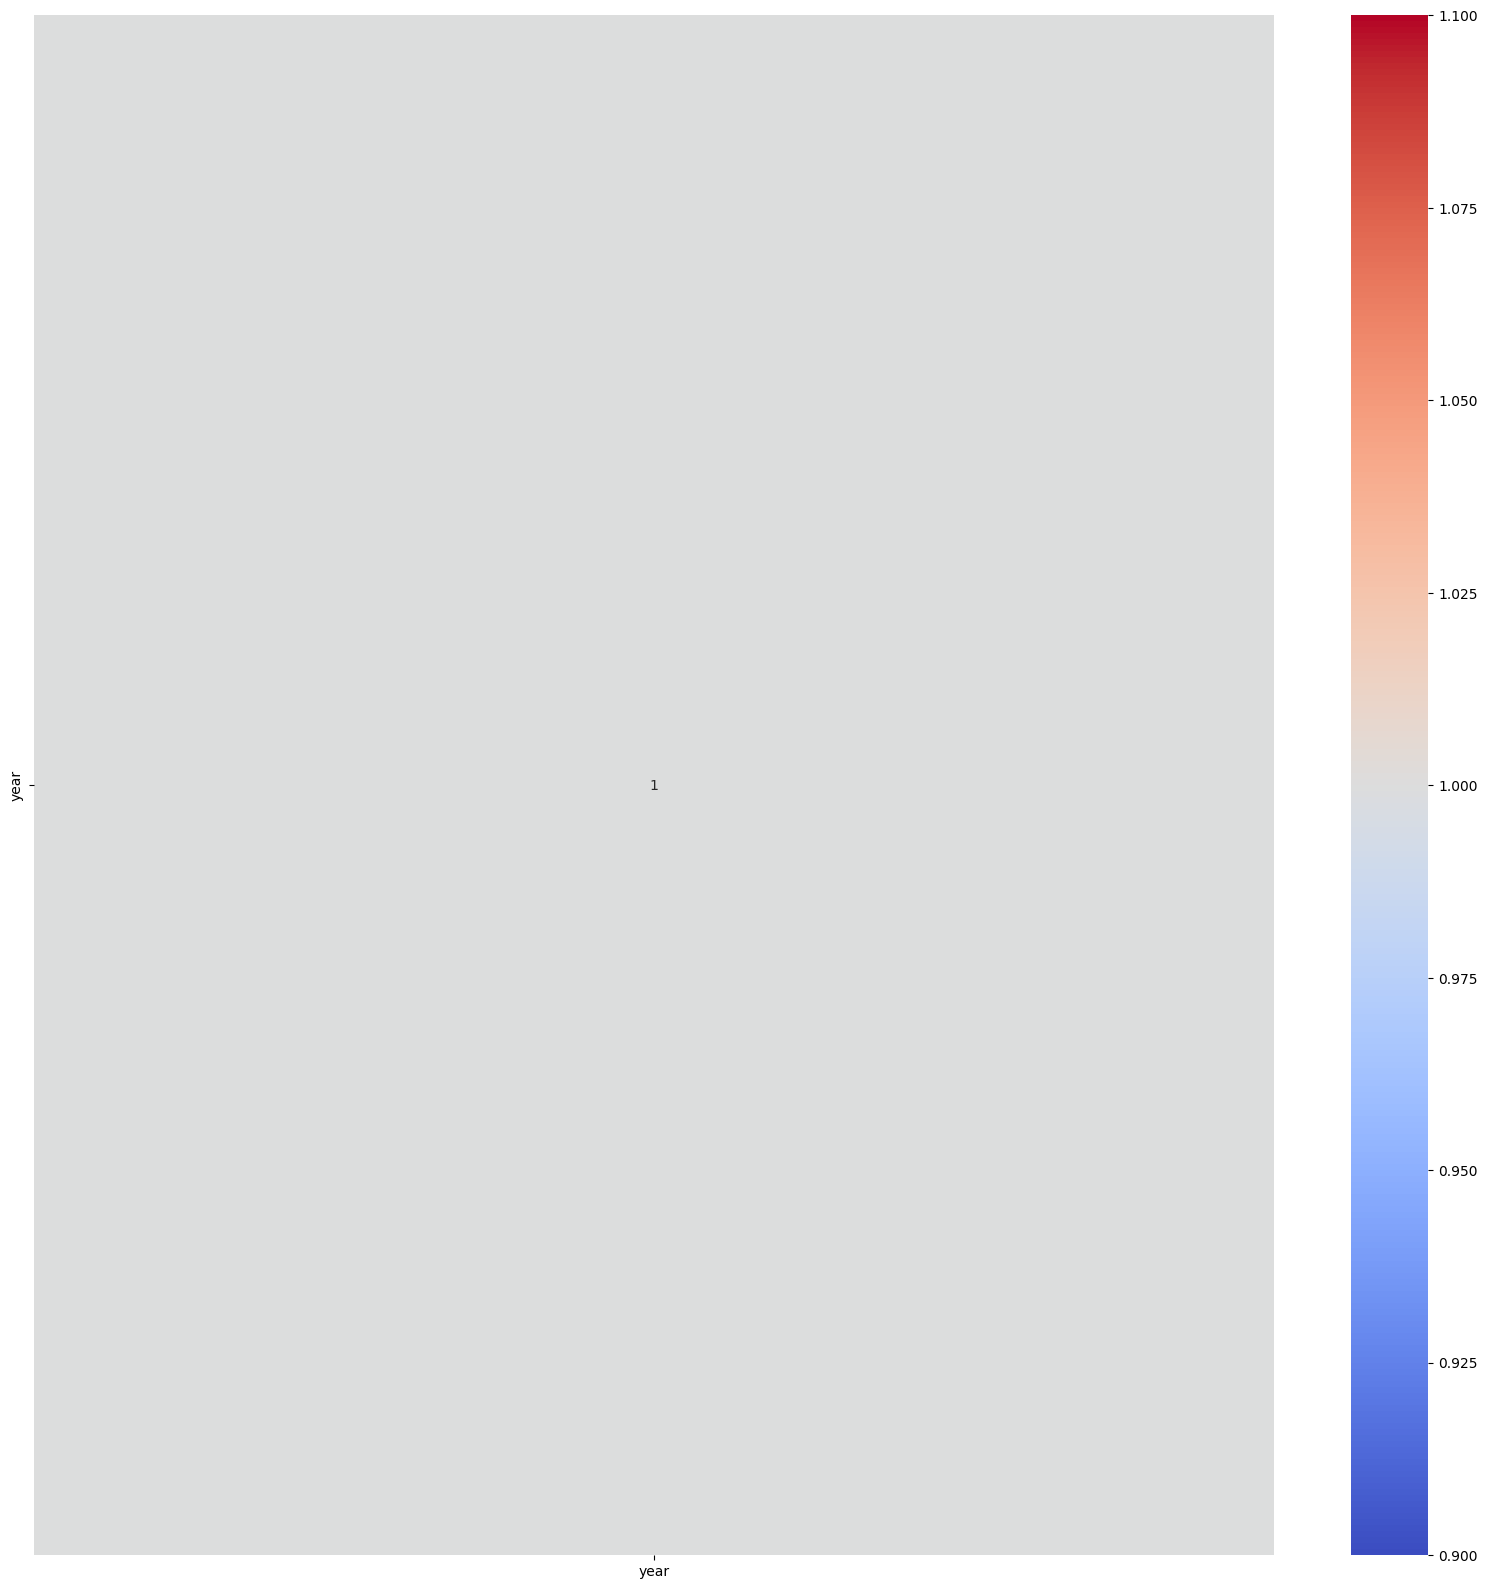

Series([], dtype: float64)
coaches_df


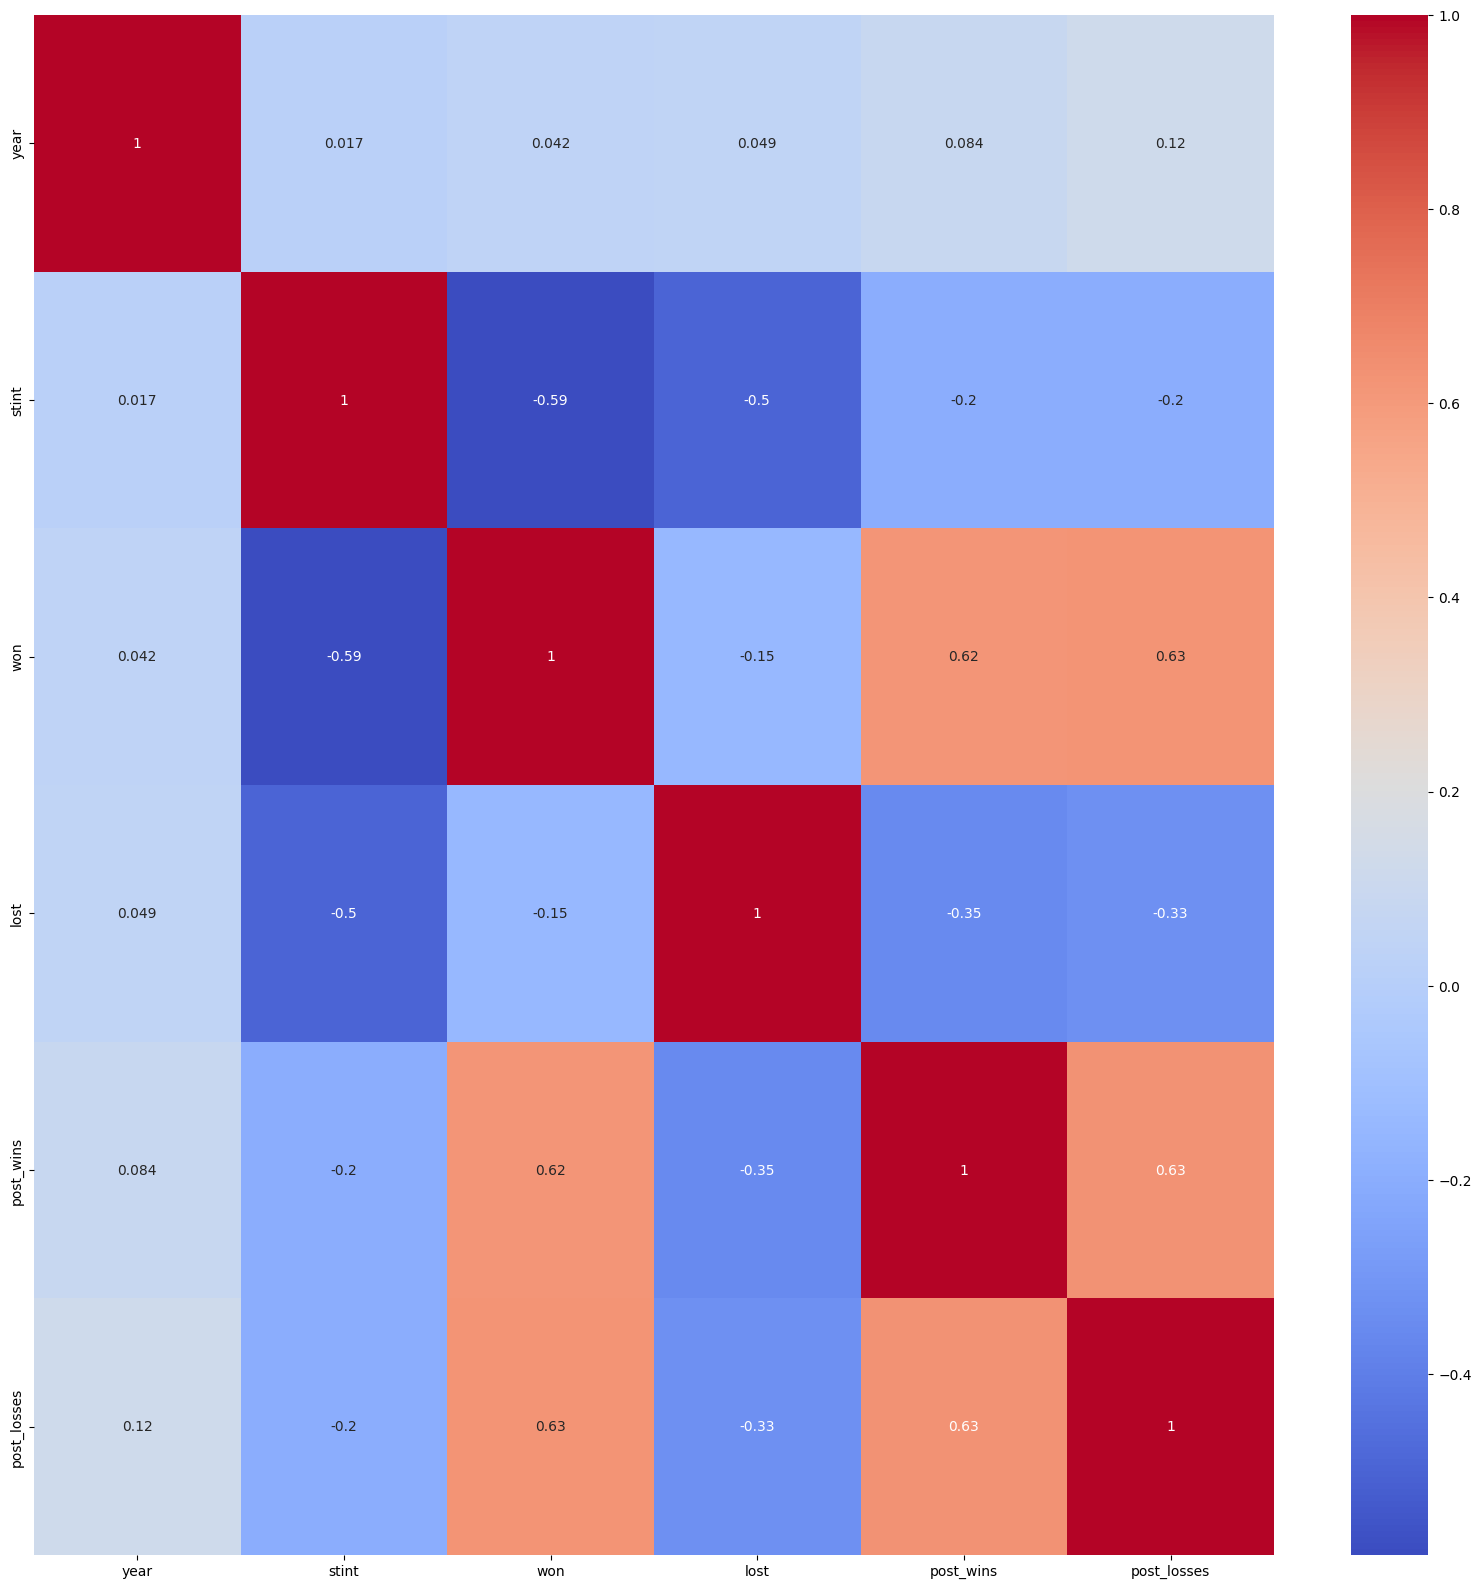

Series([], dtype: float64)
players_df


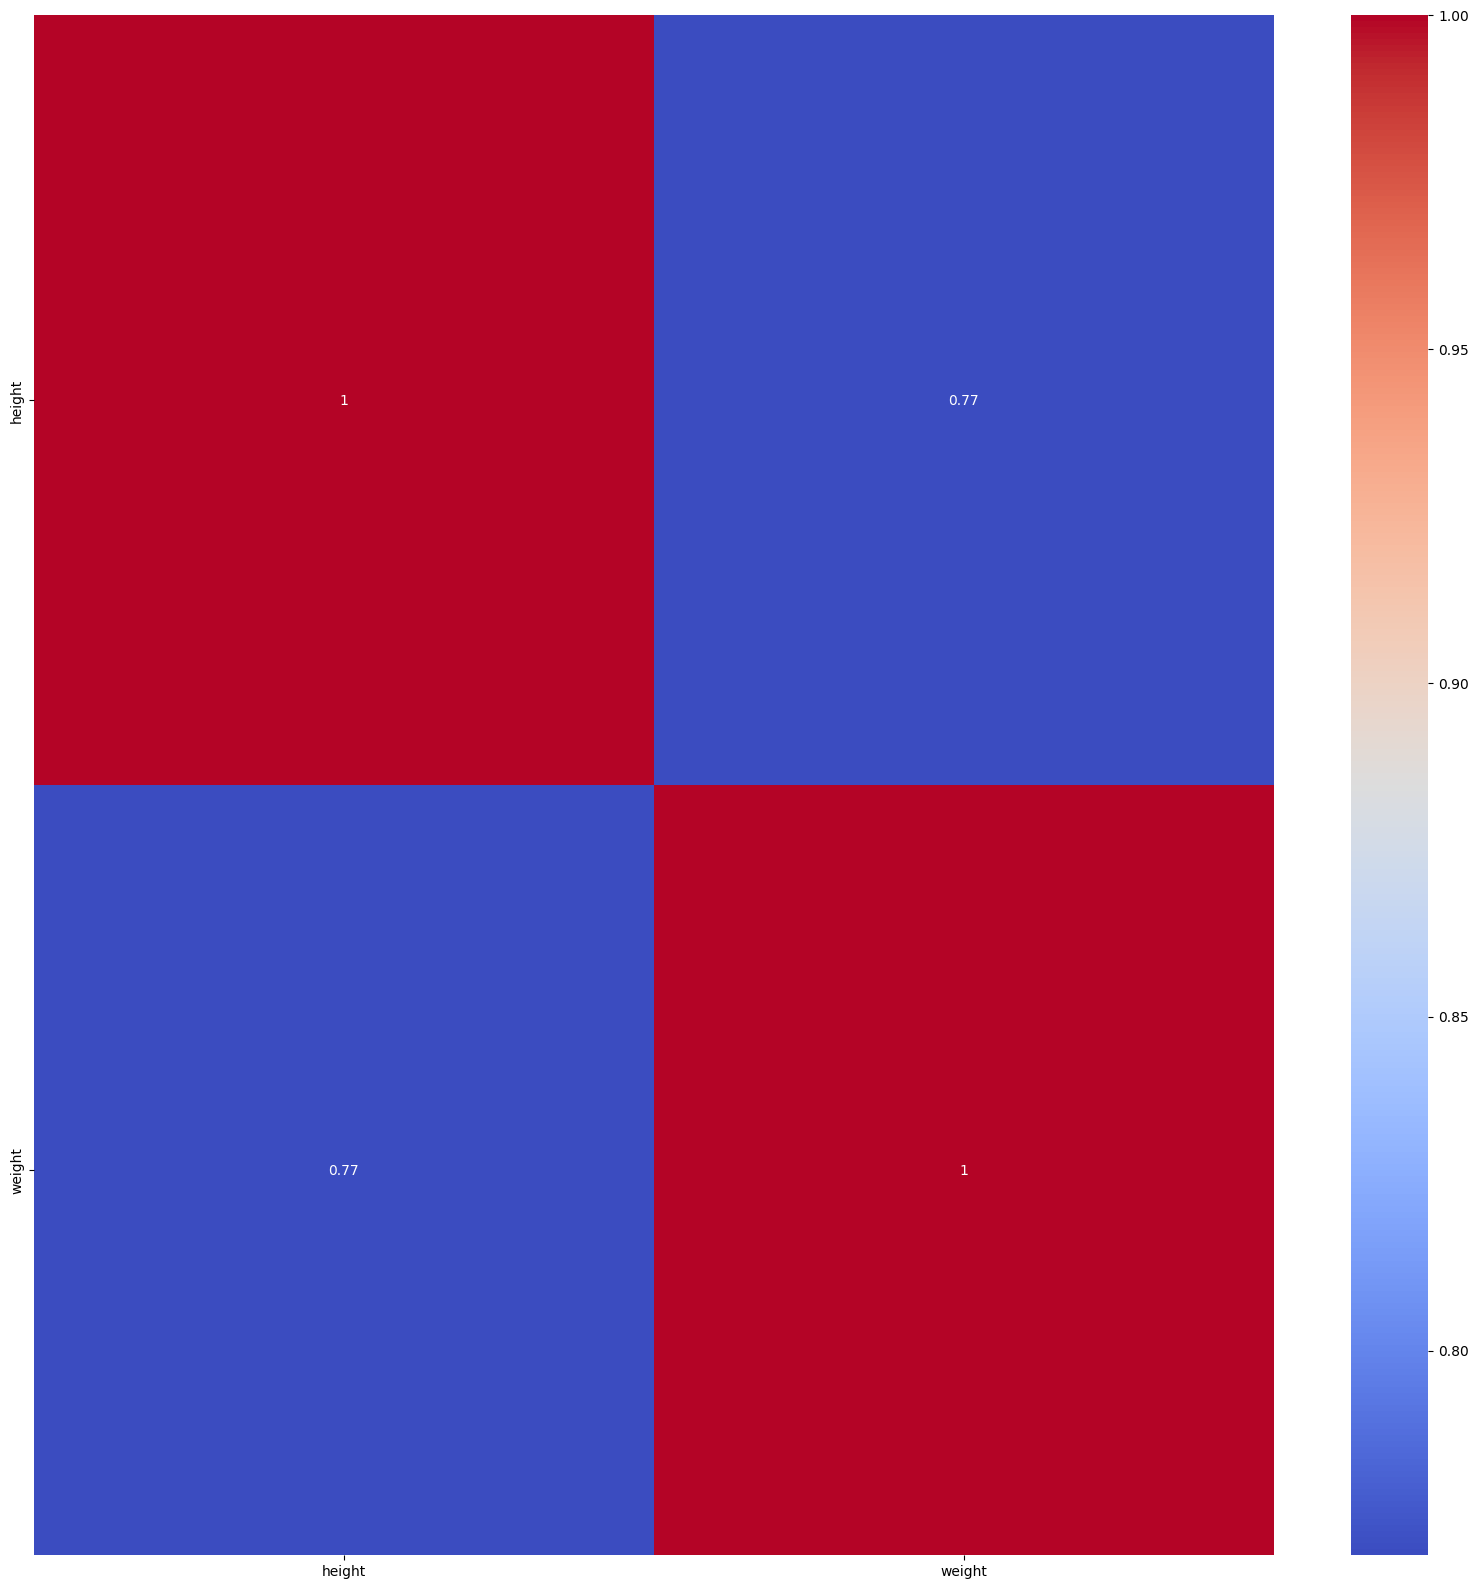

Series([], dtype: float64)
players_teams_df


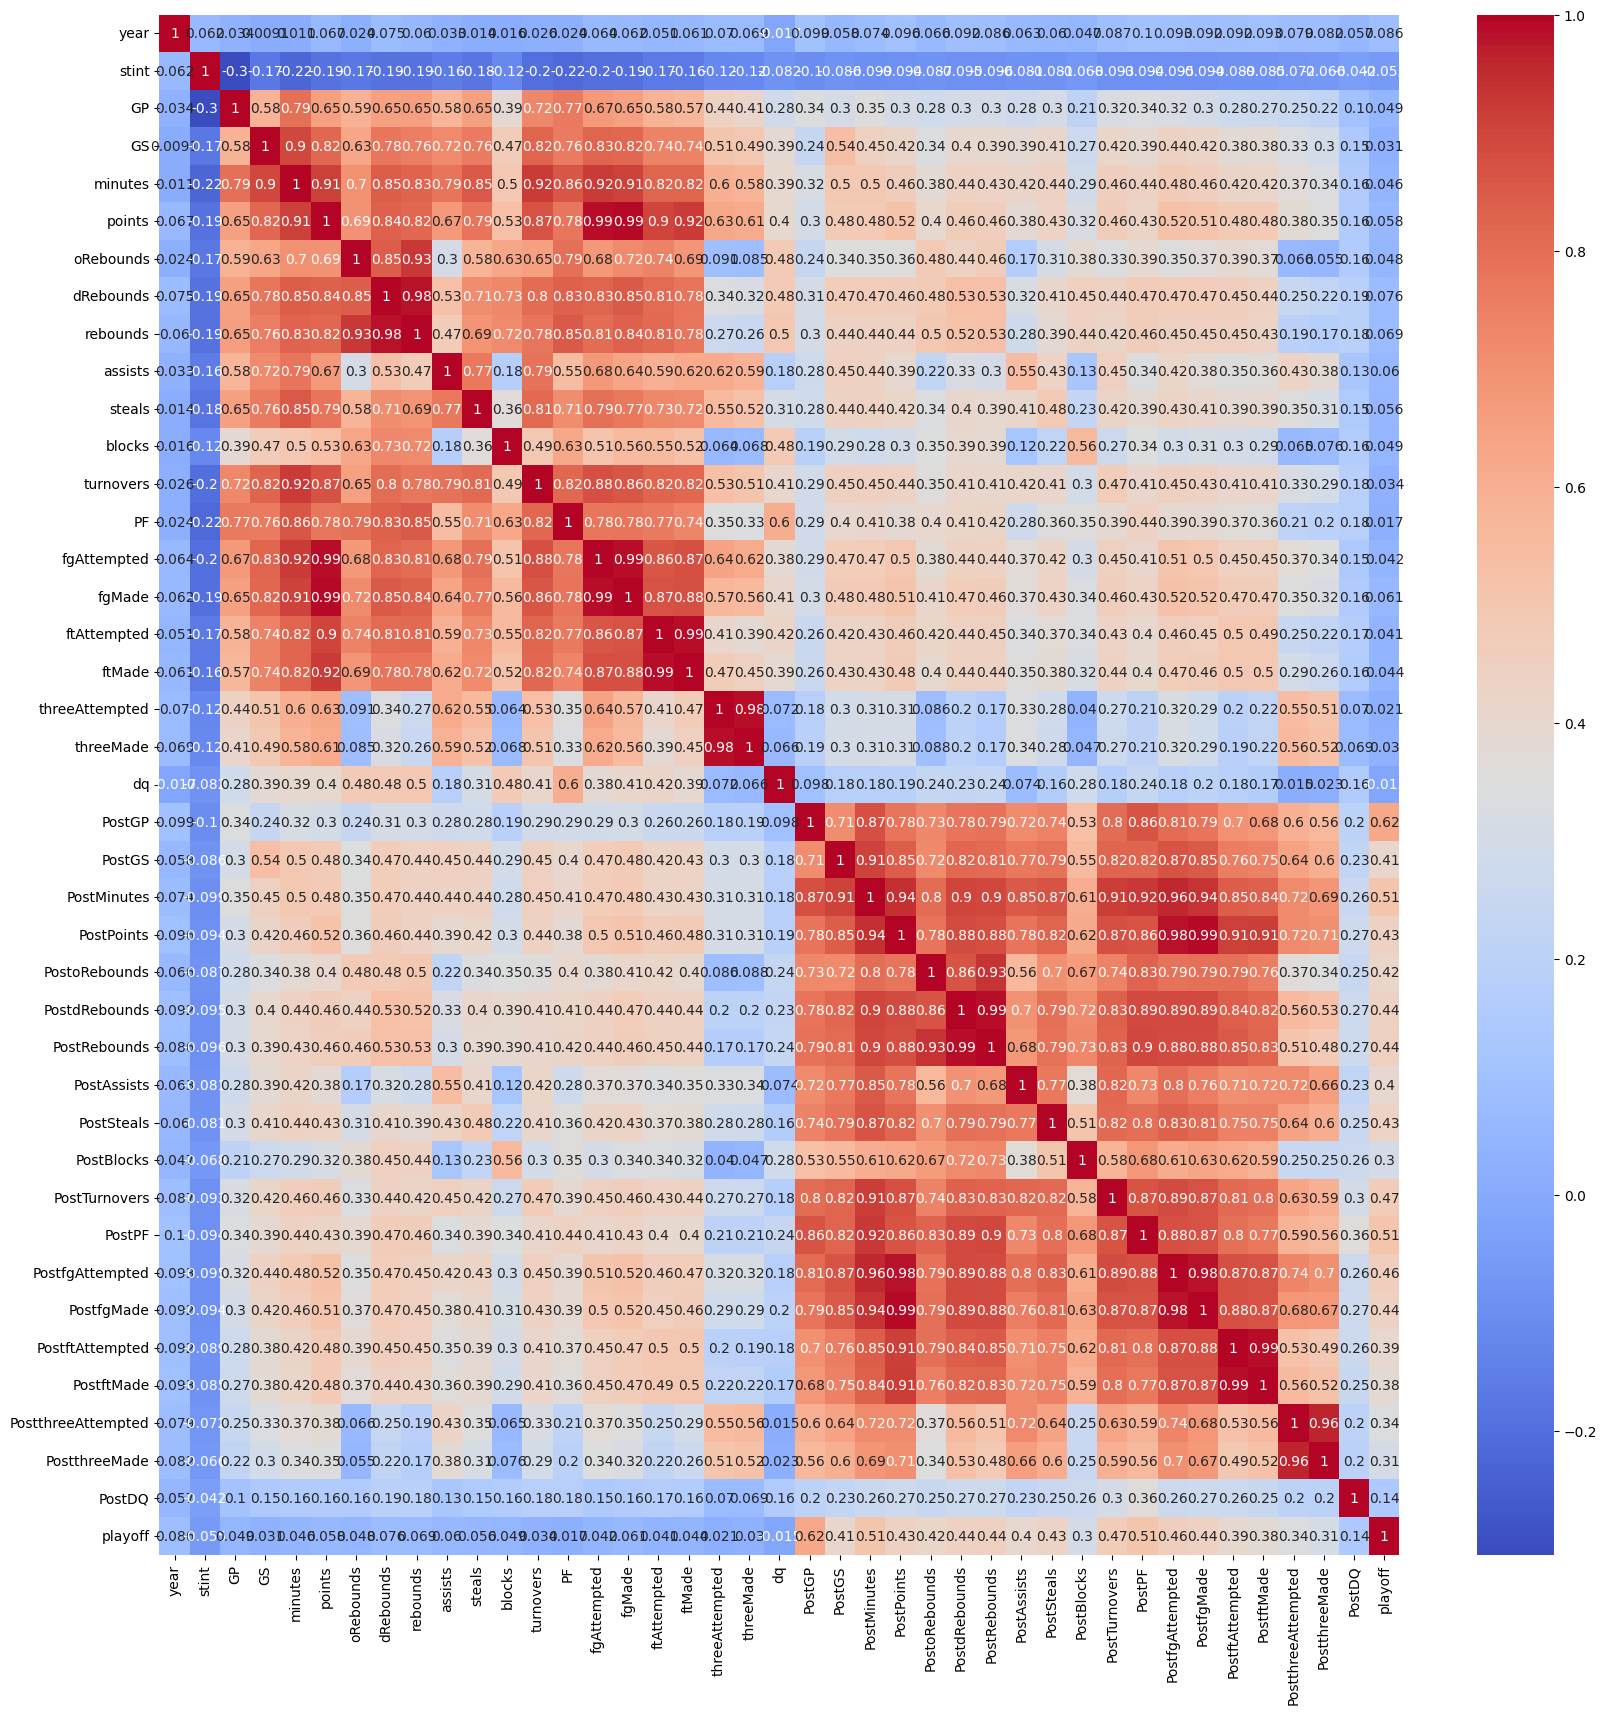

PostfgMade       PostPoints         0.992409
points           fgMade             0.990684
PostftMade       PostftAttempted    0.987716
PostdRebounds    PostRebounds       0.986737
points           fgAttempted        0.986687
                                      ...   
rebounds         fgAttempted        0.805379
PostMinutes      PostoRebounds      0.804345
turnovers        dRebounds          0.802589
PostTurnovers    PostGP             0.802462
PostfgAttempted  PostAssists        0.801153
Length: 114, dtype: float64
series_post_df


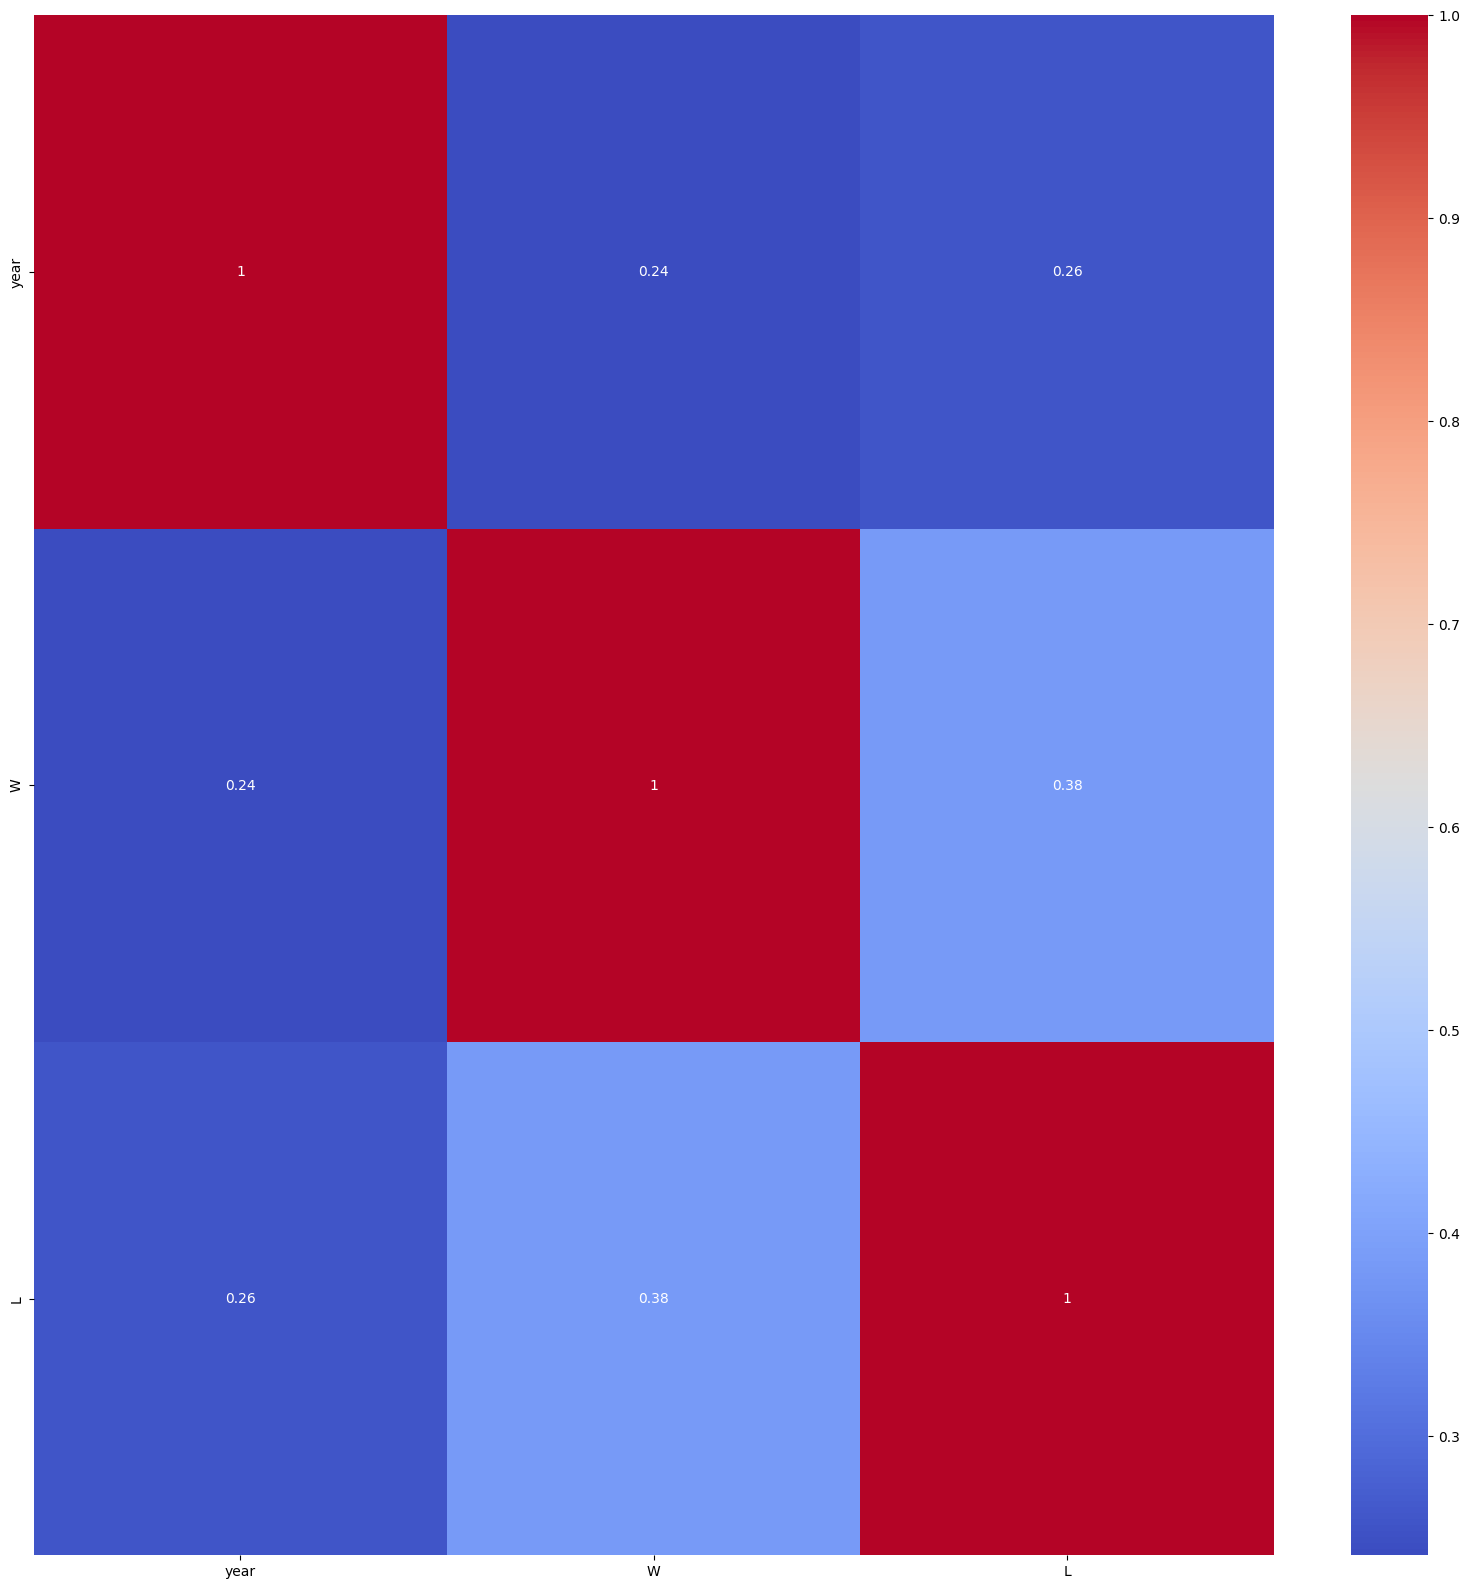

Series([], dtype: float64)
teams_df


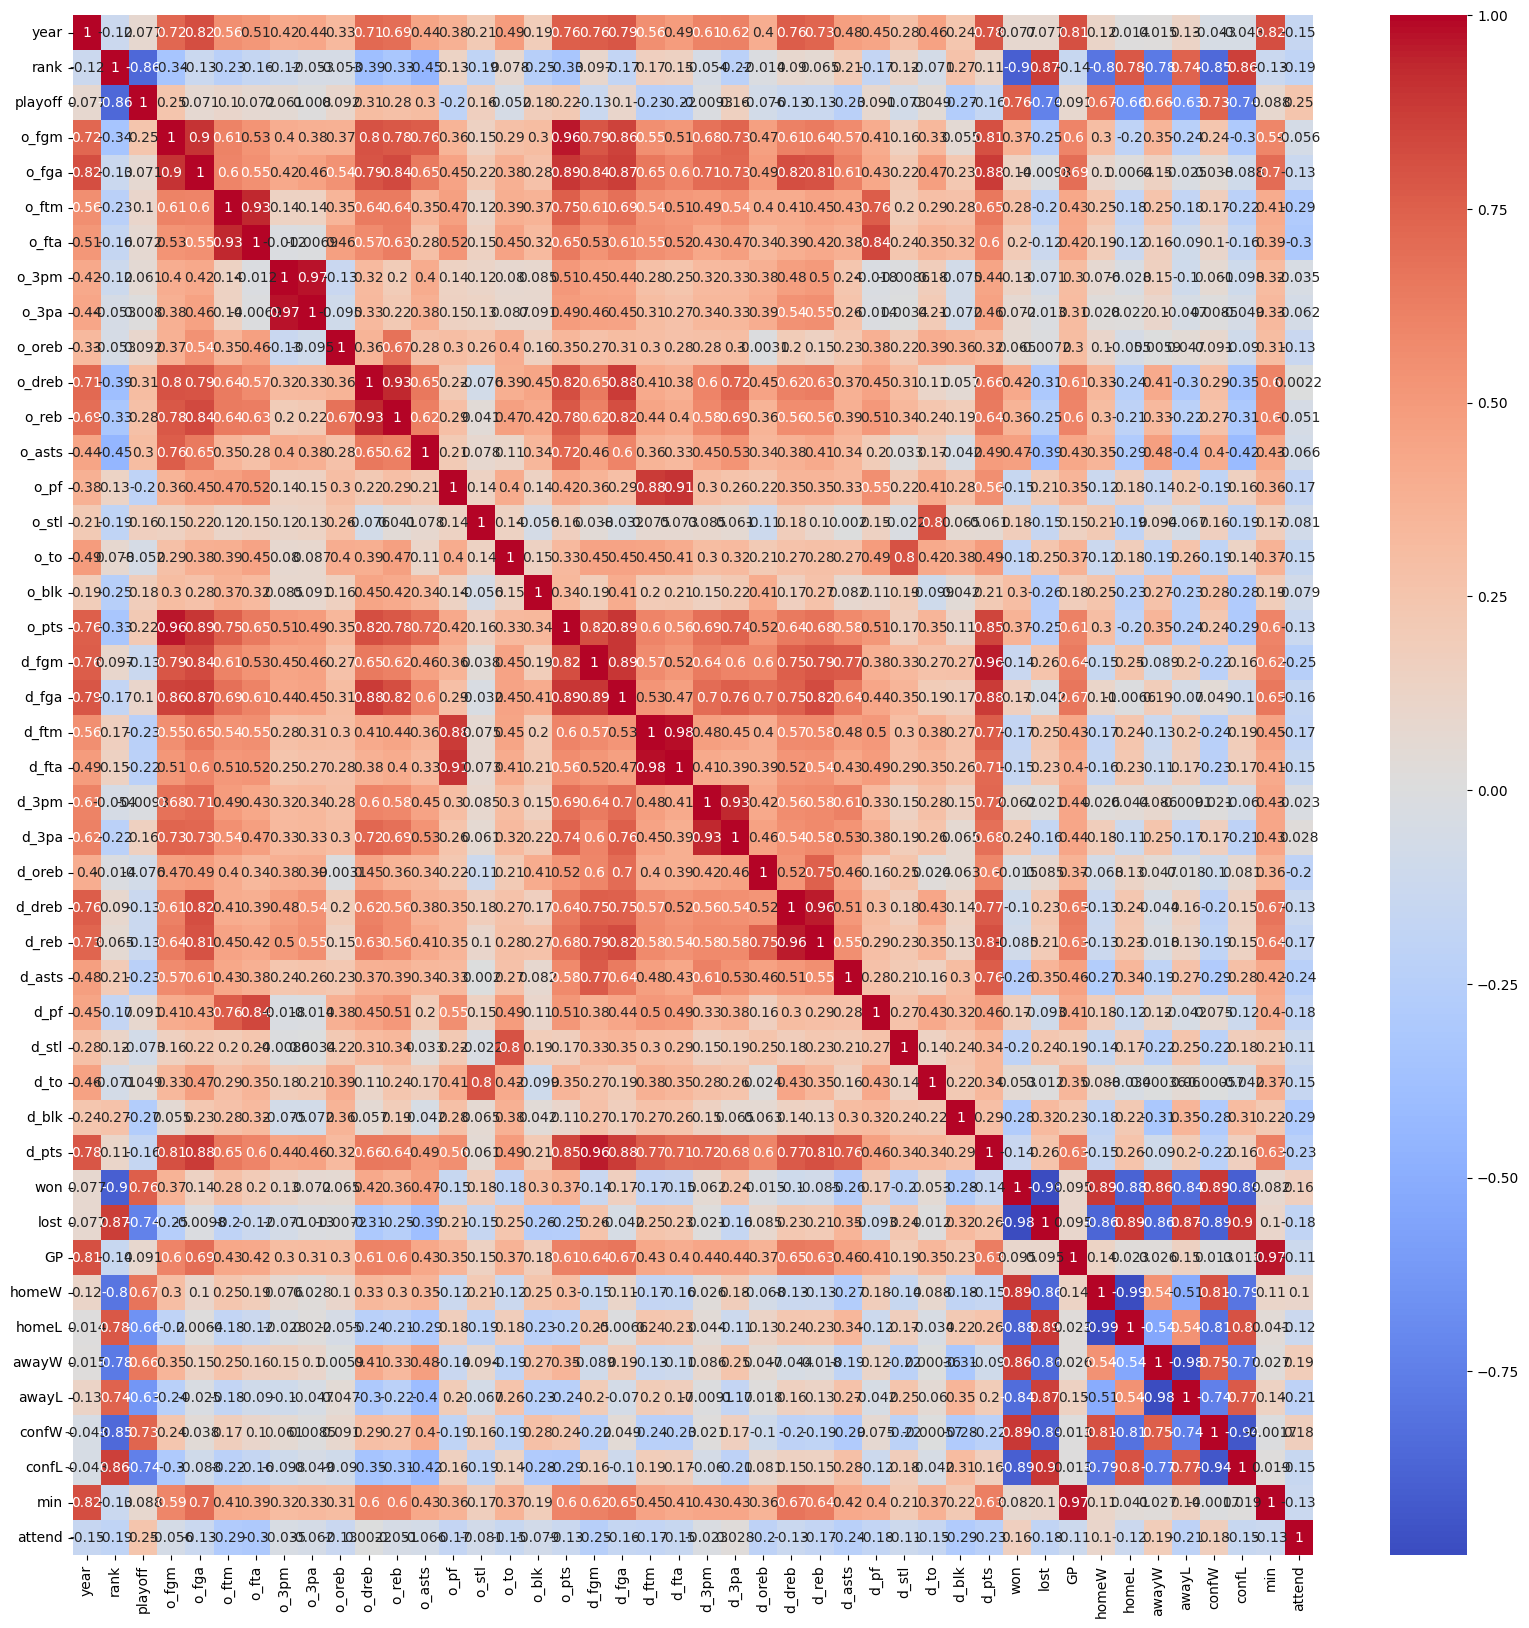

d_ftm   d_fta     0.979640
o_3pm   o_3pa     0.970076
GP      min       0.967510
o_fgm   o_pts     0.964508
d_fgm   d_pts     0.958903
d_dreb  d_reb     0.957760
d_3pm   d_3pa     0.934678
o_fta   o_ftm     0.933098
o_dreb  o_reb     0.931034
o_pf    d_fta     0.906362
o_fga   o_fgm     0.900705
confL   lost      0.896704
o_pts   o_fga     0.894379
d_fga   o_pts     0.892041
        d_fgm     0.891966
confW   won       0.891005
won     homeW     0.890399
homeL   lost      0.887680
d_fga   o_dreb    0.883308
o_pf    d_ftm     0.881446
d_pts   d_fga     0.877615
o_fga   d_pts     0.877049
d_fga   o_fga     0.874881
rank    lost      0.869440
lost    awayL     0.865894
awayW   won       0.863497
rank    confL     0.861650
d_fga   o_fgm     0.857657
o_pts   d_pts     0.848306
d_pf    o_fta     0.843435
d_fgm   o_fga     0.836257
o_reb   o_fga     0.835404
d_fga   d_reb     0.821977
year    min       0.820521
o_fga   year      0.820357
d_fgm   o_pts     0.819441
o_fga   d_dreb    0.819283
o

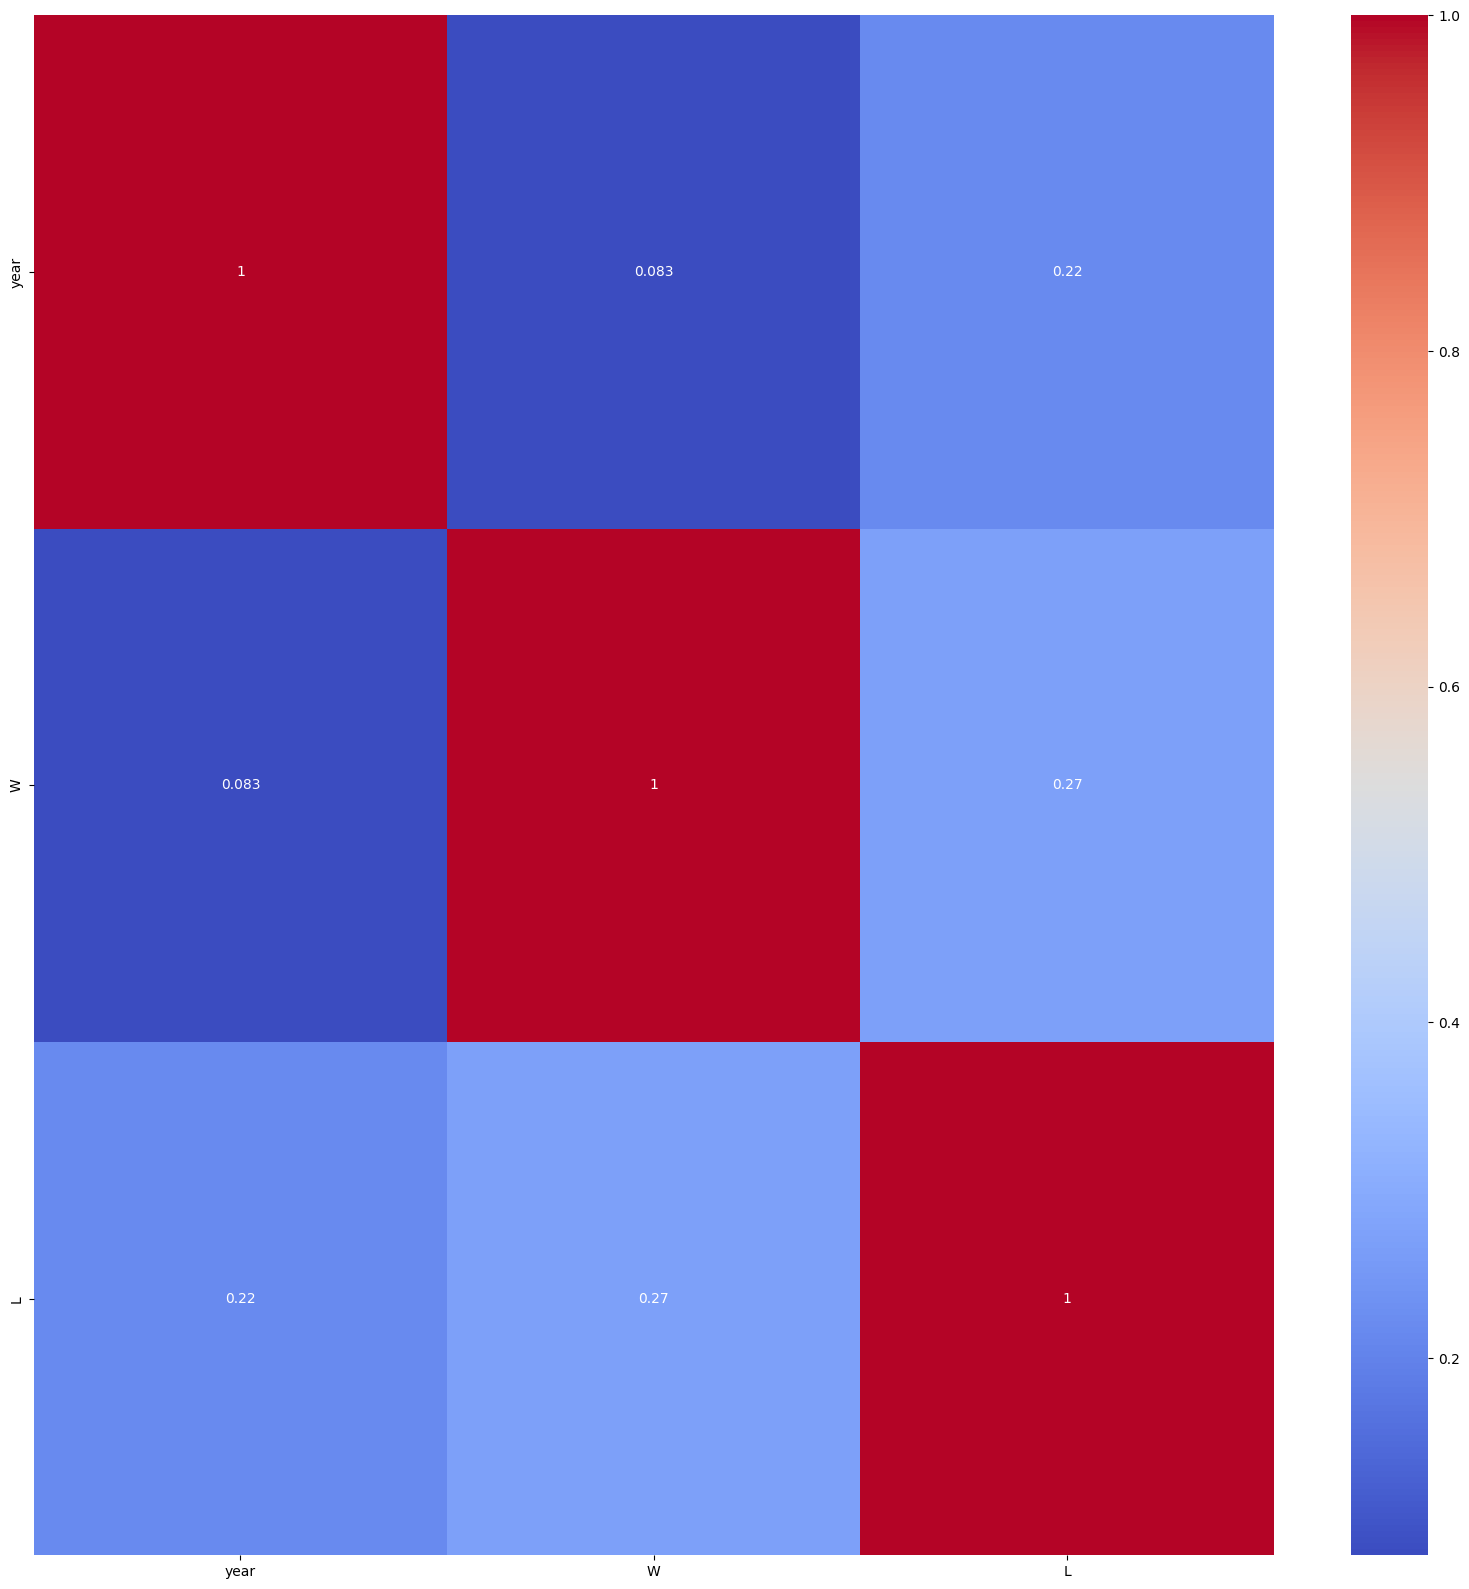

Series([], dtype: float64)


In [21]:
for df in dfs:
    print(df)
    if 'players_teams_df' in df:
        dfs[df] = went_to_playoff(dfs[df], dfs)
    #select only the numerical columns
    most_correlated(dfs[df].select_dtypes(include=np.number))

Split data in went to playoffs and did not go to playoffs and see if there are any differences

In [22]:
X = dfs['players_teams_df'].drop('playoff', axis=1)
X = X.select_dtypes(include=[np.number])
y = dfs['players_teams_df']['playoff']

# Initialize SMOTE
smote = SMOTE()

# Fit SMOTE to the data
X_balanced, y_balanced = smote.fit_resample(X, y)

# Create a new DataFrame from X_balanced
balanced_df = pd.DataFrame(X_balanced, columns=X.columns)

# Add y_balanced to the DataFrame
balanced_df['playoff'] = y_balanced

#Drop columns that start with post_
for col in balanced_df.columns:
    if col.startswith('Post'):
        balanced_df.drop(col, axis=1, inplace=True)

went_to_playoff_pt = balanced_df[balanced_df['playoff'] == 1]
not_went_to_playoff_pt = balanced_df[balanced_df['playoff'] == 0]

Make bar plots for the most important attributes to see if there are any differences

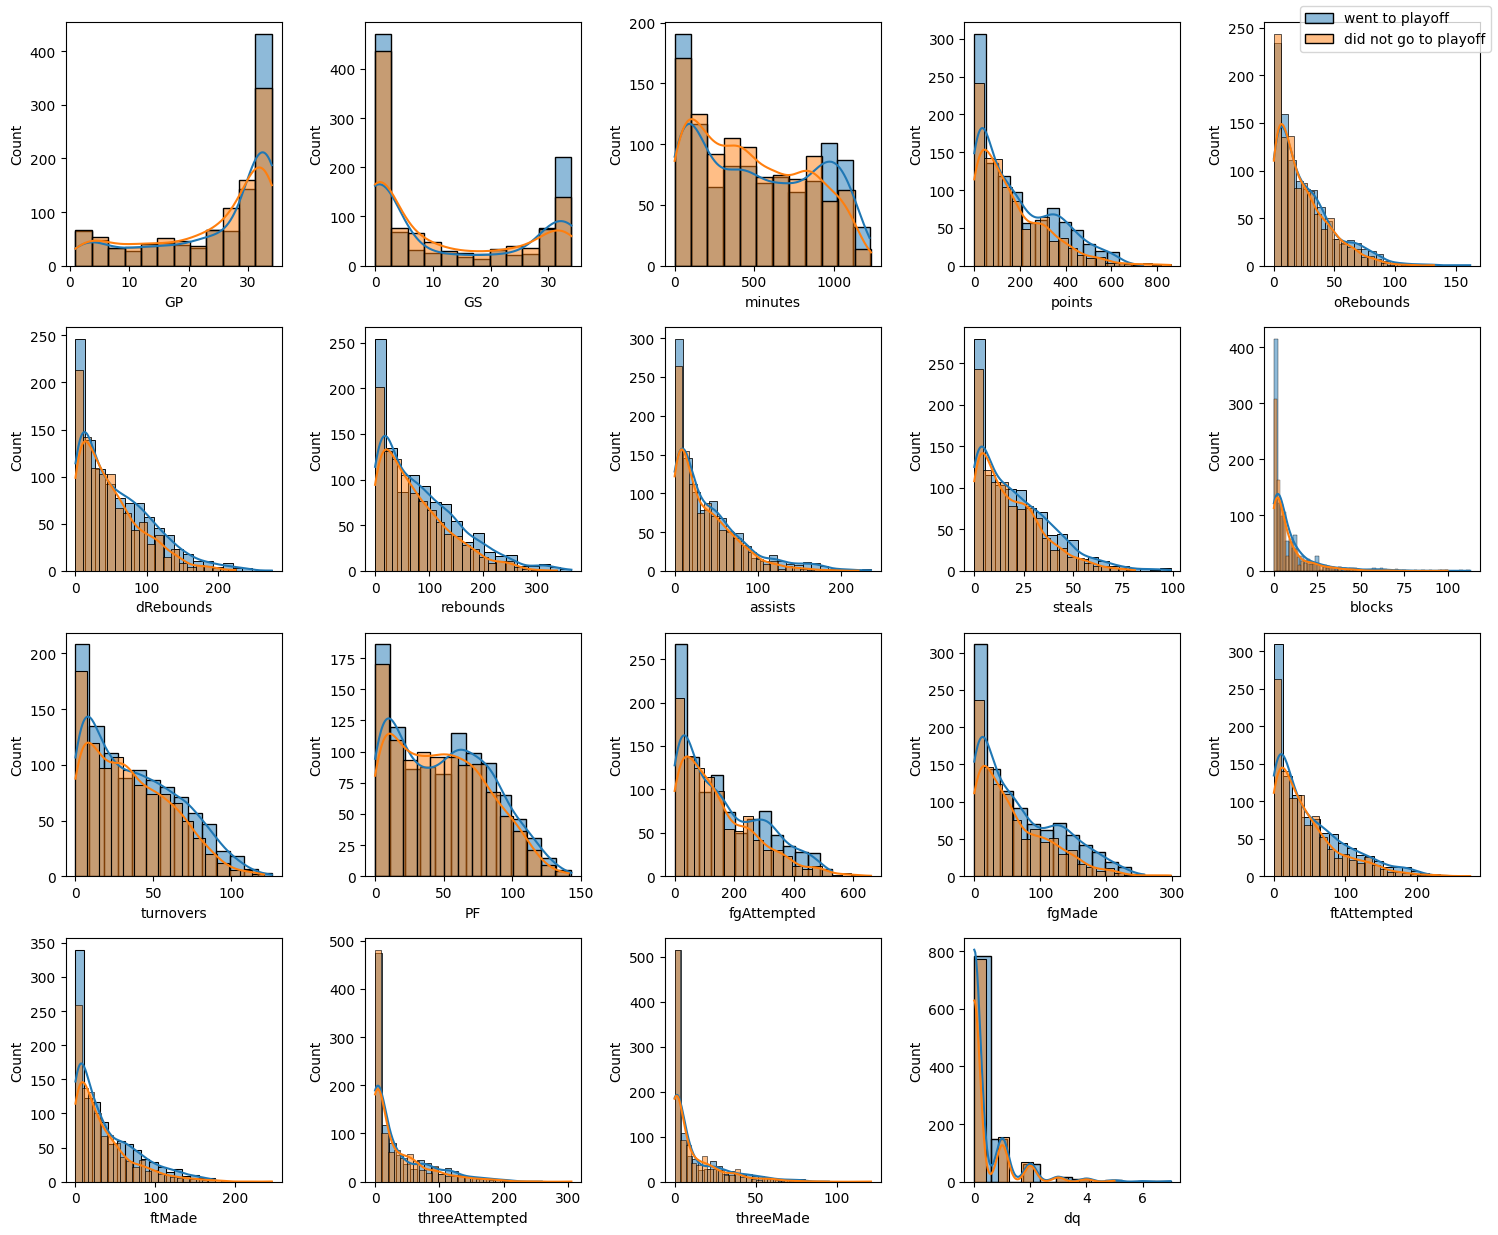

In [23]:
import math

# Get the number of columns
num_cols = len(balanced_df.columns) - 3

# Calculate the number of rows and columns for the subplot grid
grid_size = math.ceil(math.sqrt(num_cols))
fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

# Flatten the axes array
axs = axs.flatten()

# Plot each column
index = 0
for col in balanced_df.columns:
    if balanced_df[col].dtype != 'object' and col not in ['playoff', 'stint', 'year']:
        sns.histplot(went_to_playoff_pt[col], label='went to playoff', kde=True, ax=axs[index])
        sns.histplot(not_went_to_playoff_pt[col], label='did not go to playoff', kde=True, ax=axs[index])
    elif col in ['playoff', 'stint', 'year']:
        continue
    index+=1

# Add the legend to the main figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Remove unused subplots
for i in range(num_cols, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

So with that we end our understanding phase.
Our main takeaways are:
- There are dead players in the players table. We should take that into account when doing the analysis.
- There are players that have not played any season of the seasons given. We should take that into account when doing the analysis. There are 338 players that have not played any season.
- There are no Null entries (although there values that are simply an empty string)
- There are some columns with the DataType "object", most of them being strings.
- There are binary objects (like confID and playoff, in the 'teams' table, with the values "Y" or "N") that could be substituted by a binary, as well as ternary objects (like the firstRound, semis and finals in the 'teams' table, with the values "W", "L" or "") that could also be transformed.
- There are players with no position and no college assigned ("").
- There are players with no date of birth in the record (0000-00-00).
- There is the need to do null value uniformization, as there are some columns with empty strings, others with default 0 values and other values that represent null.
- The height and weight variables have default 0 values and should be treated as null values.
- The number of games played by each team differs (there may be teams that are no longer playing), so we can't compare the number of wins and losses directly. Win percentage should be used.
- In terms of win percentage, it seems like a competitive league, with more than half of the teams having a win percentage of 50% or more, taking advantage of the worst teams. There is also just one team below 40% of wins.
- There are teams that are no longer playing.
- There are a lot of highly correlated variables.
- The "Post*" variables are the most correlated with the "Playoff" variable.

In [24]:
connection.close()